In [49]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
%autoreload

import shutil
import warnings
import os.path
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import geopy
import xgboost as xgb
import os

from shapely.geometry import Point, LineString
from pyproj import Geod
from scipy import stats
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import make_scorer, mean_squared_log_error
from sklearn.model_selection import RandomizedSearchCV, KFold, GridSearchCV
from shapely import wkt
from retail_revenue_xgb import generate_features, create_buffer
from sklearn.model_selection import train_test_split
from utils import squared_log, rmsle
from xgboost import plot_importance, to_graphviz

pd.options.mode.chained_assignment = None  # default='warn'


In [54]:
spatial = pd.read_csv('data/grunnkrets_norway_stripped.csv')
age = pd.read_csv('data/grunnkrets_age_distribution.csv')
income = pd.read_csv('data/grunnkrets_income_households.csv')
households = pd.read_csv('data/grunnkrets_households_num_persons.csv')
submission = pd.read_csv('data/sample_submission.csv')
plaace = pd.read_csv('data/plaace_hierarchy.csv')
busstops = pd.read_csv('data/busstops_norway.csv')

def generate_features(df: pd.DataFrame):
    features = ['year', 'store_name', 'mall_name', 'chain_name', 'address', 'lat', 'lon',
                'plaace_hierarchy_id', 'grunnkrets_id']
    df = df[features]
    df['store_name'] = df['store_name']
    # df['store_id'] = df['store_id']
    df['address'] = df['address']
    df['chain_name+mall_name'] = (df['chain_name'] + df['mall_name'])
    df['mall_name'] = df['mall_name']
    df['chain_name'] = df['chain_name']
    df['plaace_hierarchy_id'] = df['plaace_hierarchy_id']

    # attempt to difference the lat and lon values, as they seem to be somewhat trending negatively.
    df['lon'] = df['lon'].diff()
    df['lat'] = df['lat'].diff()

    # remove duplicates and merge with the spatial data.
    spatial.drop_duplicates(subset=['grunnkrets_id'])
    df = pd.merge(df, spatial.drop_duplicates(subset=['grunnkrets_id']), how='left')
    df['grunnkrets_name'] = df['grunnkrets_name']
    df['district_name'] = df['district_name']
    df['municipality_name'] = df['municipality_name']
    df['geometry'] = df['geometry']

    # age.drop_duplicates(subset=['grunnkrets_id'])
    # df = pd.merge(df, age.drop_duplicates(subset=['grunnkrets_id']), how='left')

    income.drop_duplicates(subset=['grunnkrets_id'])
    df = pd.merge(df, income.drop_duplicates(subset=['grunnkrets_id']), how='left')

    households.drop_duplicates(subset=['grunnkrets_id'])
    df = pd.merge(df, households.drop_duplicates(subset=['grunnkrets_id']), how='left')

    plaace.drop_duplicates(subset=['plaace_hierarchy_id'])
    df = pd.merge(df, plaace.drop_duplicates(subset=['plaace_hierarchy_id']), how='left')
    df['plaace_hierarchy_id'] = df['plaace_hierarchy_id']
    df['sales_channel_name'] = df['sales_channel_name']
    df['lv1_desc'] = df['lv1_desc']
    df['lv2_desc'] = df['lv2_desc']
    df['lv3'] = df['lv3']
    df['lv3_desc'] = df['lv3_desc']
    df['lv4'] = df['lv4']
    df['lv4_desc'] = df['lv4_desc']

    gk_muni = spatial[['grunnkrets_id', 'municipality_name']]

    df = df.merge(df.groupby(['municipality_name'])['lat', 'lon'].apply(lambda x: x.sum() / (x.count()))[['lat', 'lon']], on='municipality_name', suffixes=(None, '_center'))

    def meter_distance(lat1, lon1, lat2, lon2):
        line_string = LineString([Point(lon1, lat1), Point(lon2, lat2)])
        geod = Geod(ellps="WGS84")
        return geod.geometry_length(line_string)

    print(df.columns)
    print(df.head())
    print(df.shape)
    print(df.apply(lambda row: meter_distance(row.lat, row.lon, row.lat_center, row.lon_center), axis=1))
    df['dist_to_center'] = df.apply(lambda row: meter_distance(row.lat, row.lon, row.lat_center, row.lon_center), axis=1)

    df = df.drop(columns=['grunnkrets_id', 'plaace_hierarchy_id'])

    return df


def objects_to_categories(df: pd.DataFrame):
    enc = OrdinalEncoder()
    obj_cols = X_train.select_dtypes(include=[object]).columns
    df[obj_cols] = enc.fit_transform(df[obj_cols])
    return df


train = pd.read_csv('data/stores_train.csv')
test = pd.read_csv('data/stores_test.csv')

label_name = 'revenue'
X = train.drop(columns=[label_name])
y = train[label_name]

submission = pd.read_csv('data/sample_submission.csv')
model_to_load = "modeling/0002.model"

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=.8)

X_train, X_val = generate_features(X_train), generate_features(X_val)
print(X_train.shape, y_train.shape)


C:\Users\oskar\AppData\Local\Temp/ipykernel_14108/370226729.py:55: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = df.merge(df.groupby(['municipality_name'])['lat', 'lon'].apply(lambda x: x.sum() / (x.count()))[['lat', 'lon']], on='municipality_name', suffixes=(None, '_center'))


Index(['year', 'store_name', 'mall_name', 'chain_name', 'address', 'lat',
       'lon', 'plaace_hierarchy_id', 'grunnkrets_id', 'chain_name+mall_name',
       'grunnkrets_name', 'district_name', 'municipality_name', 'geometry',
       'area_km2', 'all_households', 'singles', 'couple_without_children',
       'couple_with_children', 'other_households',
       'single_parent_with_children', 'couple_children_0_to_5_years',
       'couple_children_18_or_above', 'couple_children_6_to_17_years',
       'single_parent_children_0_to_5_years',
       'single_parent_children_18_or_above',
       'single_parent_children_6_to_17_years', 'sales_channel_name', 'lv1',
       'lv1_desc', 'lv2', 'lv2_desc', 'lv3', 'lv3_desc', 'lv4', 'lv4_desc',
       'lat_center', 'lon_center'],
      dtype='object')
   year               store_name mall_name chain_name       address       lat  \
0  2016  LOFOTEN ARCTIC HOTEL AS       NaN        NaN      SAUØYA 2       NaN   
1  2016              VIC SVOLVÆR       NaN

IndexError: index out of range

In [ ]:
# Convert columns that are not numeric to a numeric value
X_train = objects_to_categories(X_train)
X_val = objects_to_categories(X_val)

xgb1 = XGBRegressor(eval_metric=mean_squared_log_error)

def rmsle_vanilla(y_pred, y_true):
    elements = np.power(np.log1p(y_pred) - np.log1p(y_true), 2)
    return float(np.sqrt(np.sum(elements) / len(y_true)))

rmsle_scorer = make_scorer(rmsle_vanilla, greater_is_better=False)

param_dist = {'n_estimators': stats.randint(150, 1000),
              'learning_rate': stats.uniform(0.01, 0.07),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': np.arange(6, 12, 1),
              'colsample_bytree': stats.uniform(0.5, 0.45),
              'min_child_weight': stats.randint(1, 7)}

# model = RandomizedSearchCV(
#     estimator=xgb1,
#     param_distributions=param_dist,
#     n_jobs=1,
#     scoring=rmsle_scorer,
#     cv=5,
#     verbose=10
# )

# model.fit(X_train, y_train)

# print(model.best_score_)
# print(model.best_params_)

# params = model.best_params_
params = {'colsample_bytree': 0.7717138210314867, 'learning_rate': 0.047506668950627134, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 223, 'subsample': 0.9929036803032936}

In [ ]:
print(X_train.shape, y_train.shape)

(4625, 37) (10287,)


In [ ]:
# Clear buffers
folder = os.path.join(os.getcwd(), 'modeling')
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    if os.path.isfile(file_path):
        os.unlink(file_path)
        print(f'Deleted file: {file_path}')

train_buffer_path = 'modeling/train.buffer'
test_buffer_path = 'modeling/test.buffer'

dtrain = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)
dtrain.save_binary(train_buffer_path)
print(f'--> {train_buffer_path} created and saved.')

dvalid = xgb.DMatrix(data=X_val, label=y_val, enable_categorical=True)
dvalid.save_binary(test_buffer_path)
print(f'--> {test_buffer_path} created and saved.')

num_round = 999
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

print("Attempting to start training...")
bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_round,
    obj=squared_log,
    custom_metric=rmsle,
    evals=watchlist,
    early_stopping_rounds=10,
    verbose_eval=5)
print("--> model trained.")

print("Attempting to save model...")
bst.save_model(model_to_load)
print("--> model saved.")

XGBoostError: [11:45:14] C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/data.cc:452: Check failed: this->labels.Size() % this->num_row_ == 0 (1037 vs. 0) : Incorrect size for labels.

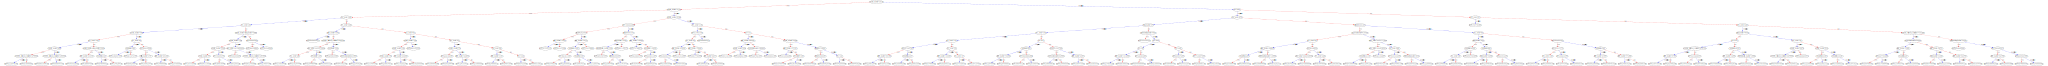

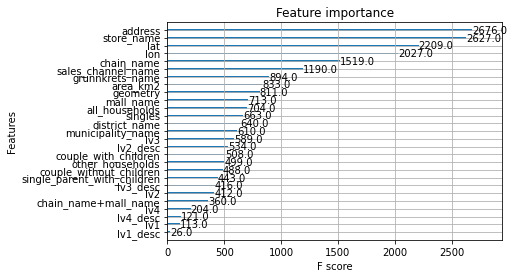

In [ ]:
from xgboost import plot_tree

plot_importance(model)
xgb.to_graphviz(model, num_trees=1)